In [1]:
import keyring
import os
OPENAI_API_KEY = keyring.get_password('openai', 'key_for_windows')
TAVILY_API_KEY = keyring.get_password('tavily', 'key_for_windows')

os.environ['OPENAI_API_KEY'] = OPENAI_API_KEY
os.environ['TAVILY_API_KEY'] = TAVILY_API_KEY

# 기억력 만들기

In [2]:
from typing import Annotated
from typing_extensions import TypedDict
from langgraph.graph.message import add_messages
from langchain_community.tools.tavily_search import TavilySearchResults
from langgraph.prebuilt import ToolNode, tools_condition
from langchain_openai import ChatOpenAI
from langgraph.graph import StateGraph

from langgraph.checkpoint.memory import MemorySaver

memory = MemorySaver()

class State(TypedDict):
    messages: Annotated[list, add_messages]

tool = TavilySearchResults(max_results=2)
tools = [tool]
tool_node = ToolNode(tools)

llm = ChatOpenAI(model='gpt-4o-mini')
llm_with_tools = llm.bind_tools(tools)

def chatbot(state: State):
    result = llm_with_tools.invoke(state['messages'])
    return {"messages": [result]}

graph_builder = StateGraph(State)

graph_builder.add_node('chatbot', chatbot)
graph_builder.add_node('tools', tool_node)

graph_builder.add_edge('tools', 'chatbot')
graph_builder.add_conditional_edges('chatbot', tools_condition)

graph_builder.set_entry_point('chatbot')
graph = graph_builder.compile(checkpointer=memory)

In [4]:
conifg = {"configurable": {"thread_id": "1"}}
while True:
    user_input = input("User: ")
    if user_input.lower() in ['quit', 'exit', 'q']:
        print('Goodbye!')
        break
    for event in graph.stream({"messages": ("user", user_input)}, conifg):
        for value in event.values():
            print("User", user_input)
            print('Assistant', value['messages'][-1].content)

User 대한민국 대통령이 누구야?
Assistant 현재 대한민국의 대통령은 윤석열입니다. 그는 제20대 대통령으로, 2022년 5월 10일부터 2027년 5월 9일까지 임기를 수행하고 있습니다.
User 내가 뭐라고 물어봤어?
Assistant 당신은 "대한민국 대통령이 누구야?"라고 물어보셨습니다.
Goodbye!


In [5]:
snapshot = graph.get_state(conifg)
snapshot

StateSnapshot(values={'messages': [HumanMessage(content='', additional_kwargs={}, response_metadata={}, id='3b58ca1c-ee19-42bc-a1bb-21c2df72a66b'), AIMessage(content='Hello! How can I assist you today?', additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 10, 'prompt_tokens': 79, 'total_tokens': 89, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-mini-2024-07-18', 'system_fingerprint': 'fp_0705bf87c0', 'finish_reason': 'stop', 'logprobs': None}, id='run-0ba832f6-a4a1-4a28-832f-e866c601649b-0', usage_metadata={'input_tokens': 79, 'output_tokens': 10, 'total_tokens': 89, 'input_token_details': {'audio': 0, 'cache_read': 0}, 'output_token_details': {'audio': 0, 'reasoning': 0}}), HumanMessage(content='대한민국 대통령은 누구야?', additional_kwargs={}, response_metadata={}, id='dfebd4

# 기억할 메시지 개수 제한하기

In [6]:
def filter_messages(messages: list):
    # this is very simple helper function which only ever uses the last message
    return messages[-2:]

def chatbot(state: State):
    messages = filter_messages(state['messages'])
    result = llm_with_tools.invoke(messages)
    return {"messages": [result]}

graph_builder = StateGraph(State)

graph_builder.add_node('chatbot', chatbot)
graph_builder.add_node('tools', tool_node)

graph_builder.add_edge('tools', 'chatbot')
graph_builder.add_conditional_edges('chatbot', tools_condition)

graph_builder.set_entry_point('chatbot')
graph = graph_builder.compile(checkpointer=memory)

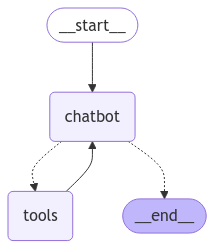

In [7]:
from IPython.display import Image, display

try:
    display(Image(graph.get_graph().draw_mermaid_png()))
except Exception:
    # this requires some extra dependencies and is optional
    pass

In [10]:
from langchain_core.messages import HumanMessage

config = {"configurable": {"thread_id": "20"}}
input_message = HumanMessage(content="hi! I'm bob and I like soccer.")
for event in graph.stream({"messages": [input_message]}, config, stream_mode="values"):
    event["messages"][-1].pretty_print()

# this will now not remember the previous messages
# (because we set `messages[-1:]` in the filter messages argument)
input_message = HumanMessage(content="what is my name?")
for event in graph.stream({"messages": [input_message]}, config, stream_mode="values"):
    event["messages"][-1].pretty_print()
    
input_message = HumanMessage(content="what's my favorite?")
for event in graph.stream({"messages": [input_message]}, config, stream_mode="values"):
    event['messages'][-1].pretty_print()


================================ Human Message =================================

hi! I'm bob and I like soccer.
================================== Ai Message ==================================

Hi Bob! That's great to hear! Soccer is an exciting sport with a huge global following. Do you have a favorite team or player?
================================ Human Message =================================

what is my name?
================================== Ai Message ==================================

Your name is Bob!
================================ Human Message =================================

what's my favorite?
================================== Ai Message ==================================

I don't have access to your personal preferences. Could you share what your favorite things are?
